5.2.2. 순전파 코드 구현

50
0
[0.74279]
1
[0.23208042]
2
[0.1664609]
3
[-0.25195543]
4
[-0.42739107]
5
[-0.68397749]
6
[-0.69106628]
7
[-0.90717174]
8
[-0.93694503]
9
[-0.98288833]
10
[-0.94850184]
11
[-0.76041411]
12
[-0.73098697]
13
[-0.531653]
14
[-0.20339042]
15
[0.1595648]
16
[0.40276428]
17
[0.59079674]
18
[0.81881247]
19
[0.94993441]
20
[1.00750712]
21
[0.98165159]
22
[1.02086797]
23
[0.73046924]
24
[0.54504741]
25
[0.58626535]
26
[0.23389098]
27
[0.11386655]
28
[-0.37054234]
29
[-0.41851496]
30
[-0.9153431]
31
[-0.95823339]
32
[-0.95340664]
33
[-1.02451204]
34
[-0.886349]
35
[-0.85272462]
36
[-0.48767785]
37
[-0.38334929]
38
[-0.41295718]
39
[-0.03193065]
Epoch:1/101 Error:2.553794589702319


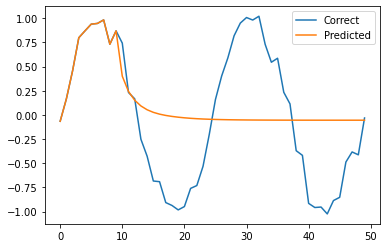

Epoch:11/101 Error:1.7479985476763573


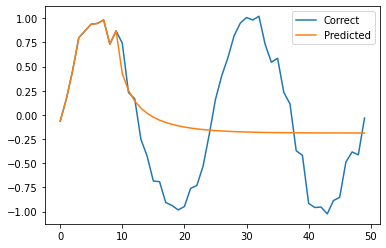

Epoch:21/101 Error:1.3223679749643211


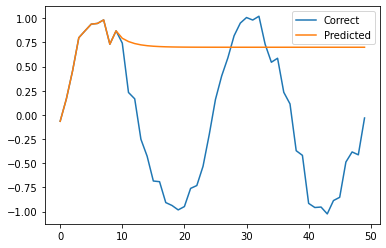

Epoch:31/101 Error:1.3188939967721975


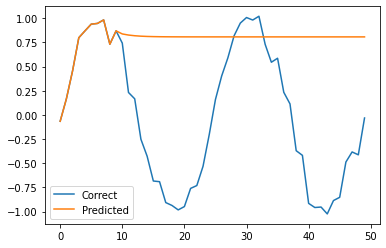

Epoch:41/101 Error:1.4109739592395827


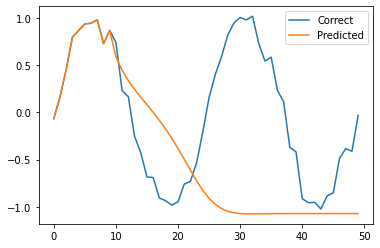

Epoch:51/101 Error:1.340654891205564


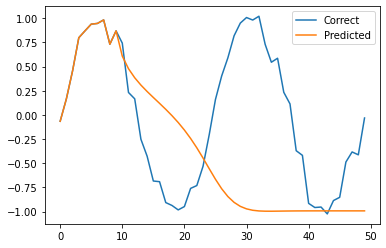

Epoch:61/101 Error:1.213615598345874


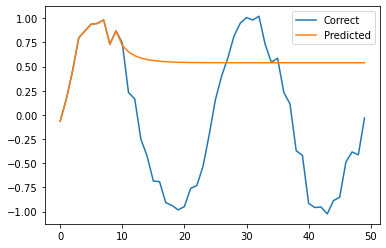

Epoch:71/101 Error:1.230452657136395


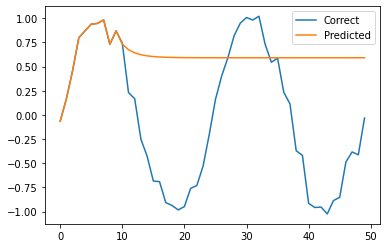

Epoch:81/101 Error:1.2856100917932762


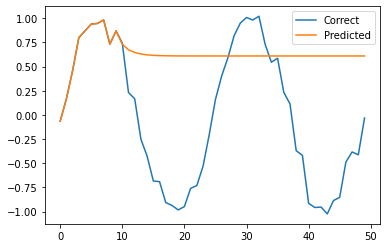

Epoch:91/101 Error:1.323974090328846


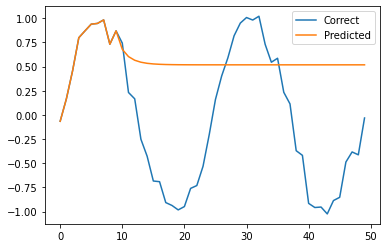

Epoch:101/101 Error:1.5602753836656476


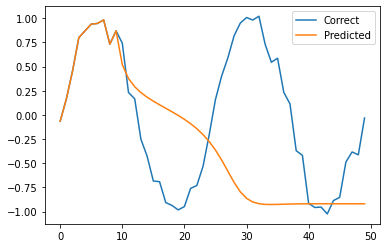

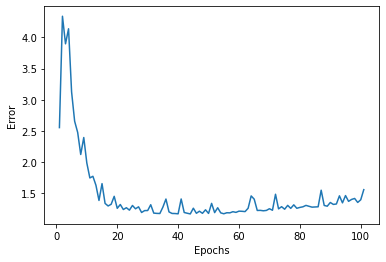

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# -- 각 설정값 --
n_time = 10      # 시점 수
n_in = 1         # 입력층 뉴런 수
n_mid = 20       # 은닉층 뉴런 수
n_out = 1        # 출력층 뉴런 수

eta = 0.01       # 학습률
epochs = 101
batch_size = 8
interval = 10    # 경과 표시 간격

def sigmoid(x):
    return 1/(1+np.exp(-x))

# -- 훈련 데이터 생성 --
sin_x = np.linspace(-2*np.pi, 2*np.pi)
print(len(sin_x))
# print(sin_x)
# plt.plot(range(len(sin_x)), sin_x)
# plt.show()

sin_y = np.sin(sin_x) + 0.1*np.random.randn(len(sin_x))
# plt.plot(range(len(sin_y)), sin_y)
# plt.show()

n_sample = len(sin_x) - n_time    # 샘플 수
input_data = np.zeros((n_sample, n_time, n_in))   # 입력
correct_data = np.zeros((n_sample, n_out))        # 정답

for i in range(0, n_sample):
    print(i)
    input_data[i] = sin_y[i:i+n_time].reshape(-1,1)
    # 정답은 입력보다 한 시점 후
#     print(input_data[i])
    correct_data[i] = sin_y[i+n_time:i+n_time+1]
    print(correct_data[i])
    
# -- LSTM층 --
class LSTMLayer:
    def __init__(self, n_upper, n):
        # 각 파라미터의 초깃값
        self.w = np.random.randn(4, n_upper, n) / np.sqrt(n_upper)
        self.v = np.random.randn(4, n, n) / np.sqrt(n)
        self.b = np.zeros((4,n))
        
    def forward(self, x, y_prev, c_prev):
        u = np.matmul(x, self.w) + np.matmul(y_prev, self.v) + self.b.reshape(4,1,-1)
        
        a0 = sigmoid(u[0])        # 망각 게이트
        a1 = sigmoid(u[1])        # 입력 게이트
        a2 = np.tanh(u[2])        # 새로운 기억
        a3 = sigmoid(u[3])        # 출력 게이트
        self.gates = np.stack((a0, a1, a2,a3))
        
        self.c = a0*c_prev + a1*a2      # 기억 셀
        self.y = a3*np.tanh(self.c)     # 출력
        
    def backward(self, x,y,c,y_prev, c_prev, gates, grad_y, grad_c):
        a0, a1, a2,a3 = gates
        tanh_c = np.tanh(c)
        r = grad_c + (grad_y*a3) + (1-tanh_c**2)
        
        # 각 delta
        delta_a0 = r * c_prev * a0 * (1-a0)
        delta_a1 = r * a2 * a1 * (1-a1)
        delta_a2 = r * a1 * (1 - a2**2)
        delta_a3 = grad_y * tanh_c * a3 * (1-a3)
        
        deltas = np.stack((delta_a0, delta_a1, delta_a2, delta_a3))
        
        # 각 파라미터의 기울기
        self.grad_w += np.matmul(x.T, deltas)
        self.grad_v += np.matmul(y_prev.T, deltas)
        self.grad_b += np.sum(deltas, axis=1)
        
        # x 기울기
        grad_x = np.matmul(deltas, self.w.transpose(0,2,1))
        self.grad_x = np.sum(grad_x, axis=0)
        
        # y_prev 기울기
        grad_y_prev = np.matmul(deltas, self.v.transpose(0,2,1))
        self.grad_y_prev = np.sum(grad_y_prev, axis=0)
        
        # c_prev 기울기
        self.grad_c_prev = r * a0
        
    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b
        
# -- 전결합 출력층 --
class OutputLayer:
    def __init__(self, n_upper, n):
        # 자비에르 초기화 기반의 초깃값
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u    # 항등함수
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
        
# -- 각 층의 초기화 --
lstm_layer = LSTMLayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

# -- 훈련 --
def train(x_mb, t_mb):
    # 순전파 LSTM층
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    c_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    gates_rnn = np.zeros((4, len(x_mb), n_time, n_mid))
    y_prev = y_rnn[:, 0, :]
    c_prev = c_rnn[:, 0, :]
    
    for i in range(n_time):
        x = x_mb[:, i, :]
        lstm_layer.forward(x, y_prev, c_prev)
        
        y = lstm_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y
        
        c = lstm_layer.c
        c_rnn[:, i+1, :] = c
        c_prev = c
        
        gates = lstm_layer.gates
        gates_rnn[:, :, i, :] = gates
        
    # 순전파 출력층
    output_layer.forward(y)
    
    # 역전파 출력층
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x
    grad_c = np.zeros_like(lstm_layer.c)
    
    # 역전파 LSTM층
    lstm_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        c = c_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        c_prev = c_rnn[:, i, :]
        gates = gates_rnn[:, :, i, :]
        
        lstm_layer.backward(x, y, c, y_prev, c_prev, gates, grad_y, grad_c)
        grad_y = lstm_layer.grad_y_prev
        grad_c = lstm_layer.grad_c_prev
        
    # 파라미터 갱신
    lstm_layer.update(eta)
    output_layer.update(eta)
    
# -- 예측 --
def predict(x_mb):
    # 순전파 LSTM층
    y_prev = np.zeros((len(x_mb), n_mid))
    c_prev = np.zeros((len(x_mb), n_mid))
    
    for i in range(n_time):
        x = x_mb[:, i, :]
        lstm_layer.forward(x, y_prev, c_prev)
        y = lstm_layer.y
        y_prev = y
        c = lstm_layer.c
        c_prev = c
        
    # 순전파 출력층
    output_layer.forward(y)
    
    return output_layer.y

# -- 오차 계산 --
def get_error(x, t):
    y = predict(x)
    return 1.0/2.0*np.sum(np.square(y - t))    # 오차제곱합

error_record = []
n_batch = len(input_data) // batch_size         # 1에포크당 배치 개수
for i in range(epochs):
    
    # -- 학습 --
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)             # 인덱스 임의 섞기
    for j in range(n_batch):
        # 미니 배치 구성
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)
        
    # -- 오차 계산 --
    error = get_error(input_data, correct_data)
    error_record.append(error)
    
    # -- 경과 표시 --
    if i%interval == 0:
        print("Epoch:"+str(i+1)+"/"+str(epochs), "Error:"+str(error))
        
        predicted = input_data[0].reshape(-1).tolist()   # 최초 입력
        for i in range(n_sample):
            x = np.array(predicted[-n_time:]).reshape(1, n_time, 1)
            y = predict(x)
            # 출력을 predicted에 추가
            predicted.append(float(y[0, 0]))
            
        plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()
        
plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()